<a href="https://colab.research.google.com/github/siwookim1114/Data-Science-Projects/blob/main/Netflix_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Stock Price Prediction

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt

## Read Data

In [4]:
file_path = "/content/drive/MyDrive/ML AI/Data Science Projects/Data/NFLX.csv"
df = pd.read_csv(file_path)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


### Column Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


## Data Preprocessing

### Check for Null Values

In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check for Outliers

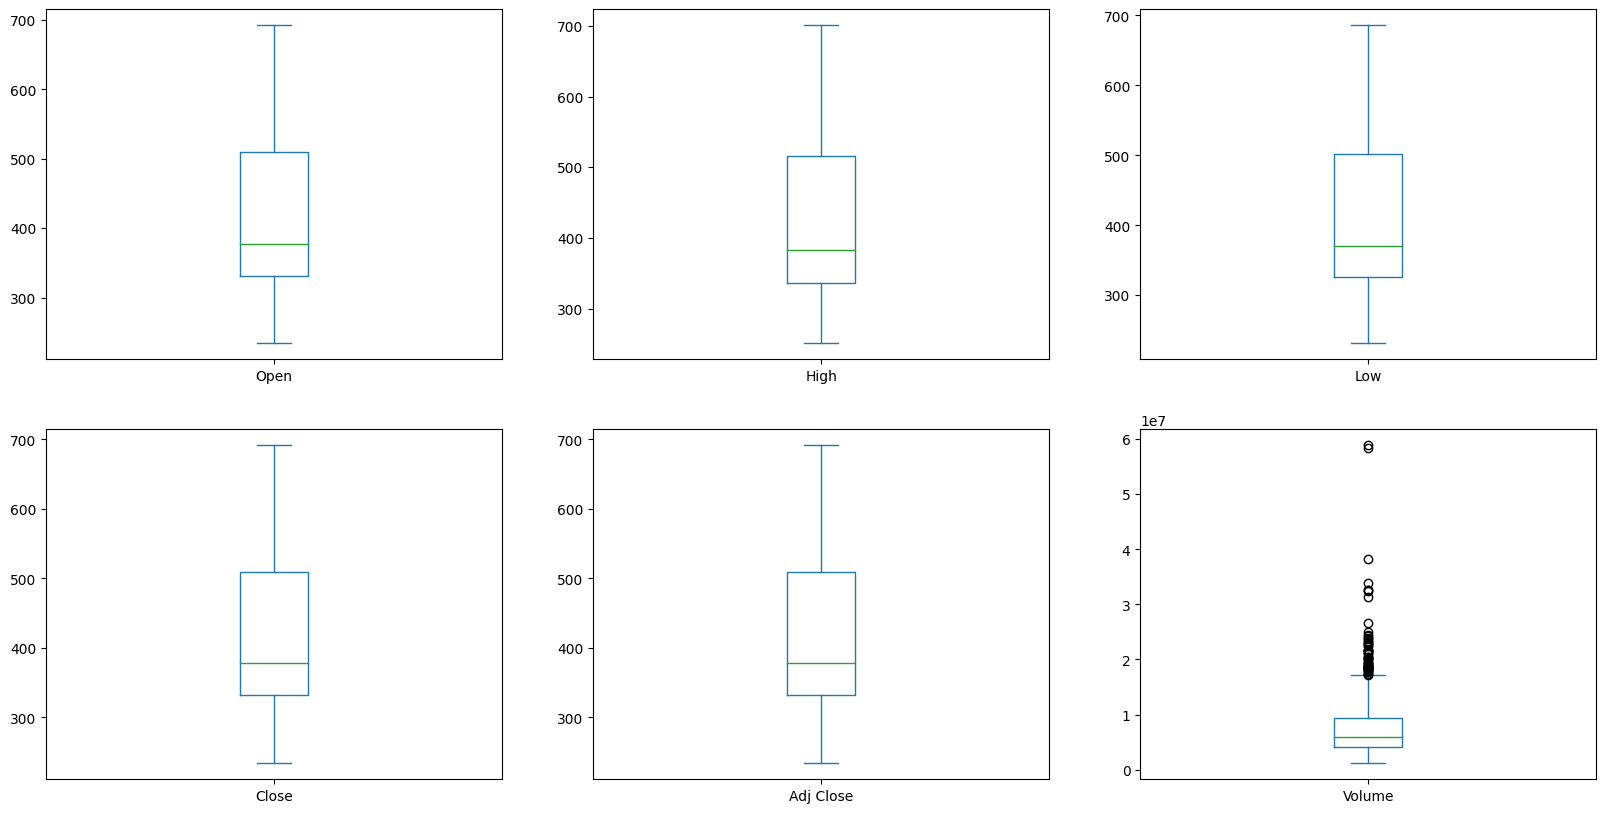

In [8]:
# Create boxplot to check for outliers for each column
fig , ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))

# Plots
df["Open"].plot(kind = "box", ax = ax1)
df["High"].plot(kind = "box", ax = ax2)
df["Low"].plot(kind = "box", ax = ax3)
df["Close"].plot(kind = "box", ax = ax4)
df["Adj Close"].plot(kind = "box", ax = ax5)
df["Volume"].plot(kind = "box", ax = ax6)

plt.show()


### Covert Date Column Type

In [9]:
## Convert dtype from object to datetime
df["Date"] = pd.to_datetime(df["Date"])
df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5 non-null      datetime64[ns]
 1   Open       5 non-null      float64       
 2   High       5 non-null      float64       
 3   Low        5 non-null      float64       
 4   Close      5 non-null      float64       
 5   Adj Close  5 non-null      float64       
 6   Volume     5 non-null      int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 408.0 bytes


In [10]:
## Set to index
df.set_index("Date", inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


### Data Statistics Overview


In [11]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


## Exploratory Data Analysis

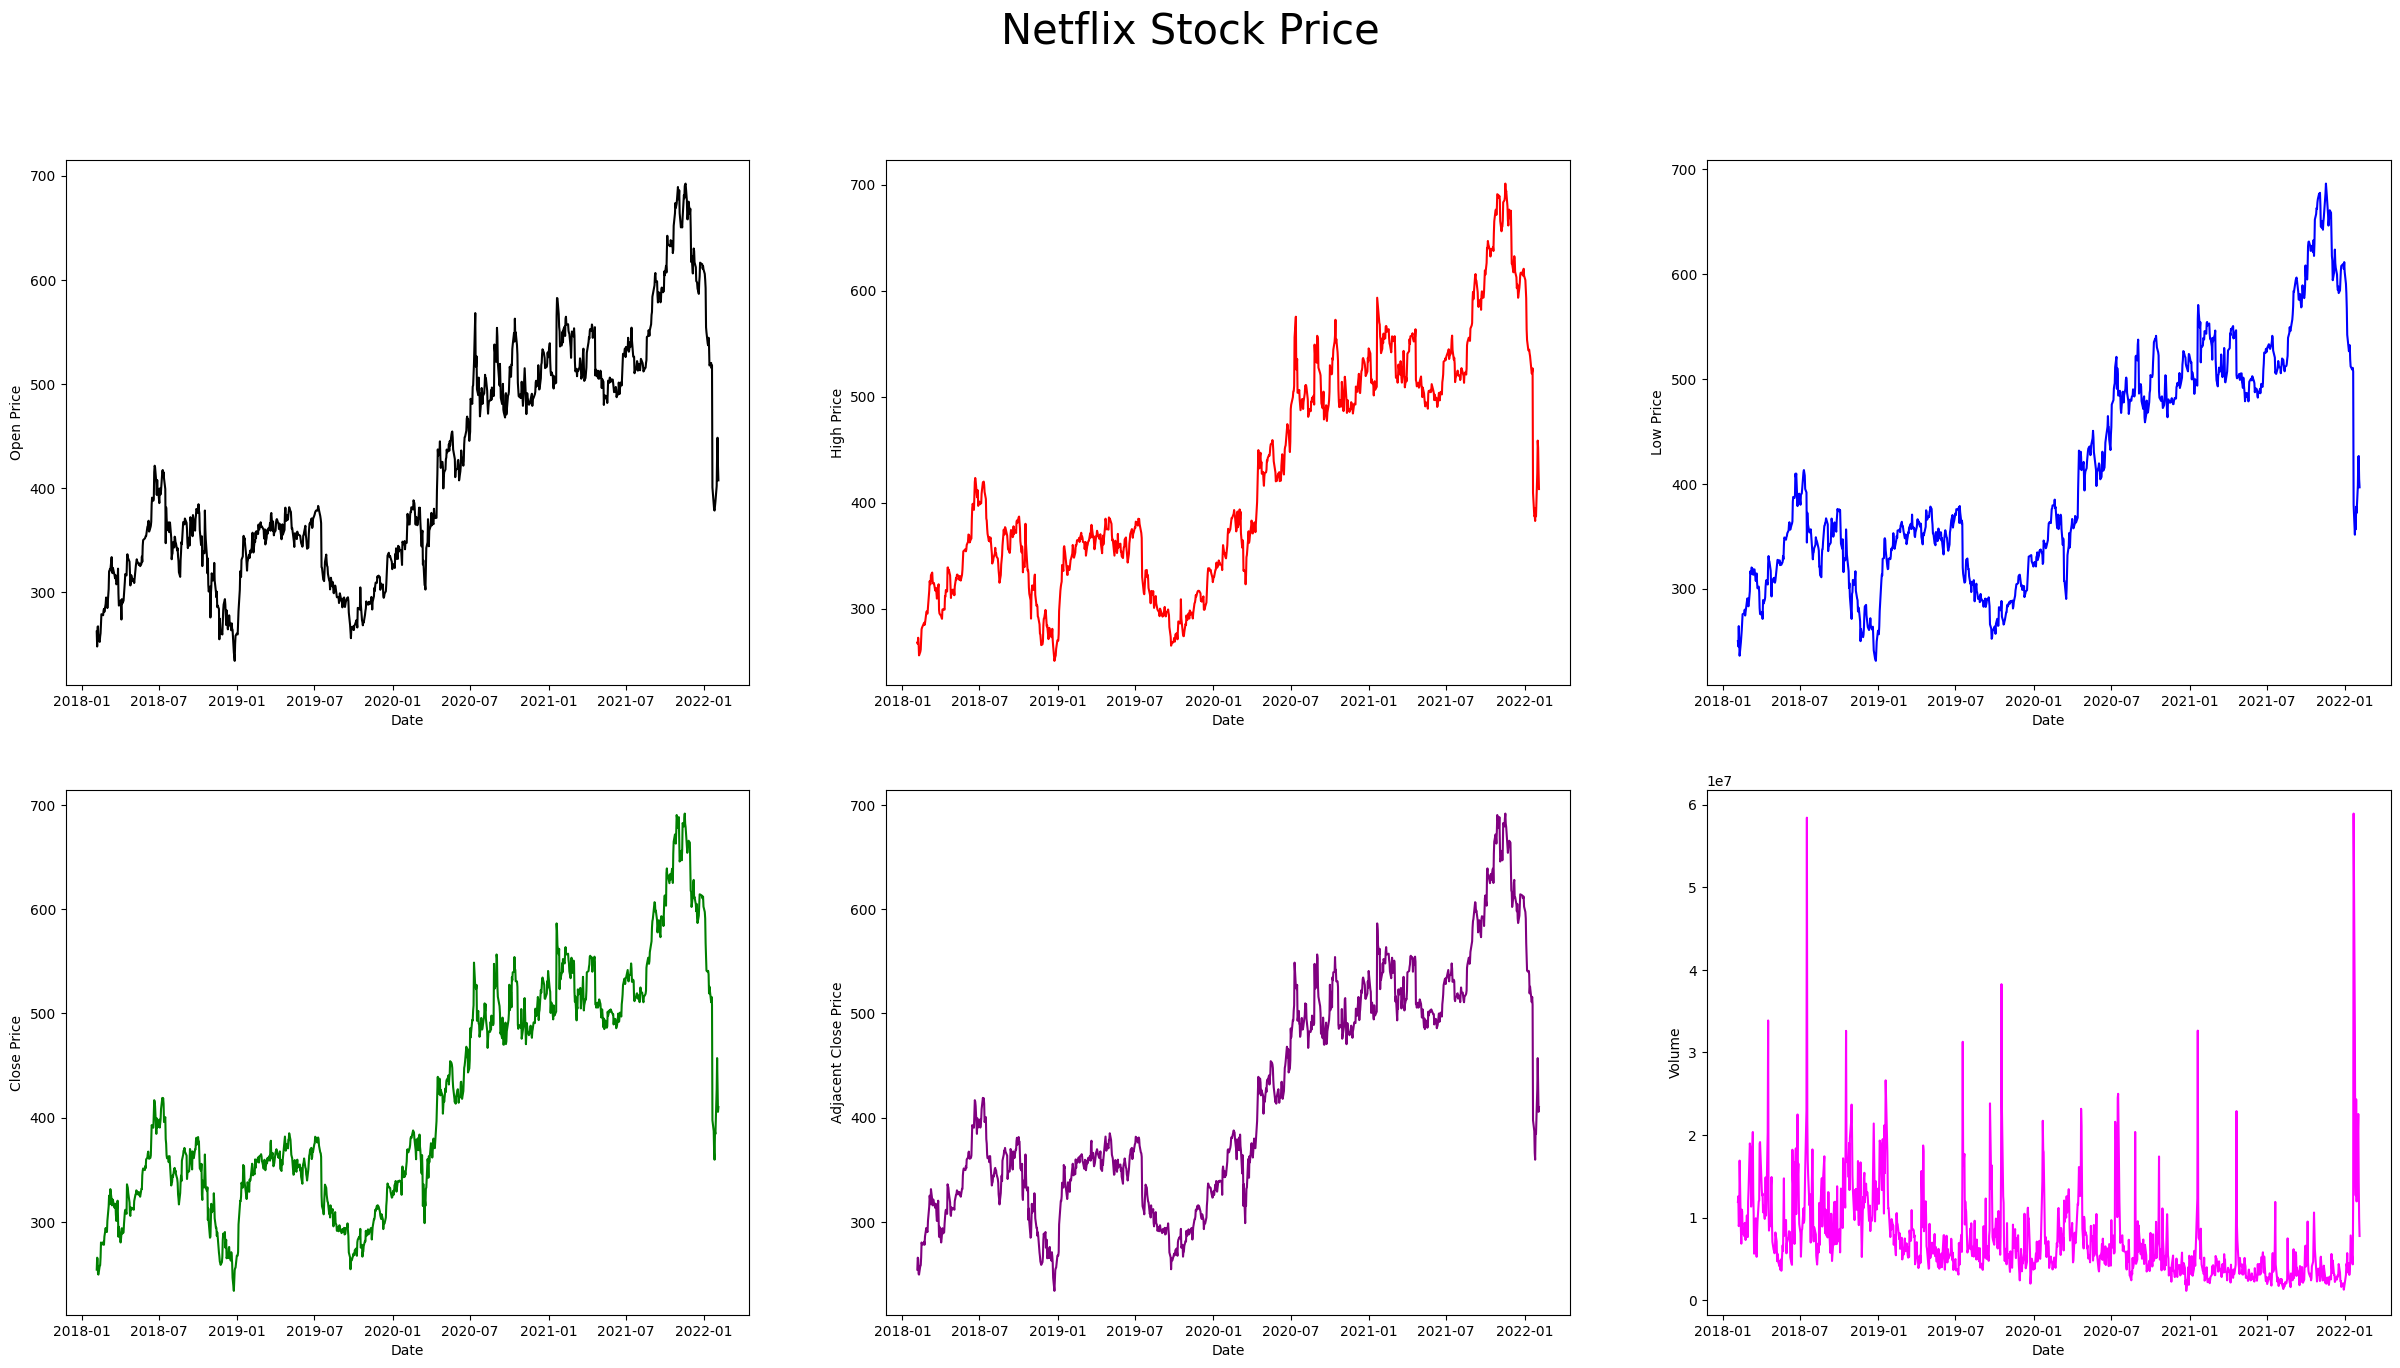

In [12]:
## Graph of all Open, High, Low, Close, Adj Close, and Volume by Date
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (30, 15))
fig.suptitle("Netflix Stock Price", fontsize = 30)

# Open
ax1.plot(df.index, df["Open"], color = "black")
ax1.set_xlabel("Date")
ax1.set_ylabel("Open Price")

# High
ax2.plot(df.index, df["High"], color = "red")
ax2.set_xlabel("Date")
ax2.set_ylabel("High Price")

# Low
ax3.plot(df.index, df["Low"], color = "blue")
ax3.set_xlabel("Date")
ax3.set_ylabel("Low Price")

# Close
ax4.plot(df.index, df["Close"], color = "green")
ax4.set_xlabel("Date")
ax4.set_ylabel("Close Price")

# Adj Close
ax5.plot(df.index, df["Adj Close"], color = "purple")
ax5.set_xlabel("Date")
ax5.set_ylabel("Adjacent Close Price")

# Volume
ax6.plot(df.index, df["Volume"], color = "magenta")
ax6.set_xlabel("Date")
ax6.set_ylabel("Volume")

plt.show()


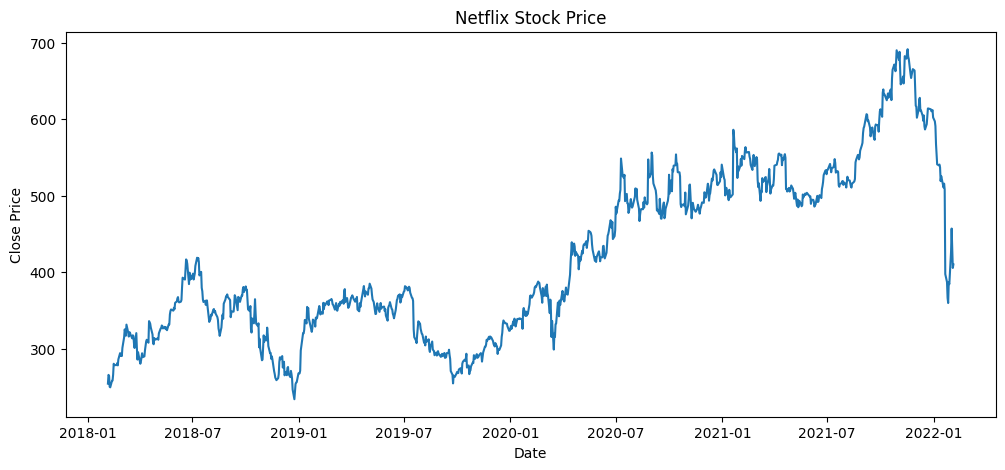

In [13]:
## Graph of all close price from the start to end
plt.figure(figsize = (12, 5))
plt.plot(df.index, df.loc[:, "Close"])
plt.title("Netflix Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

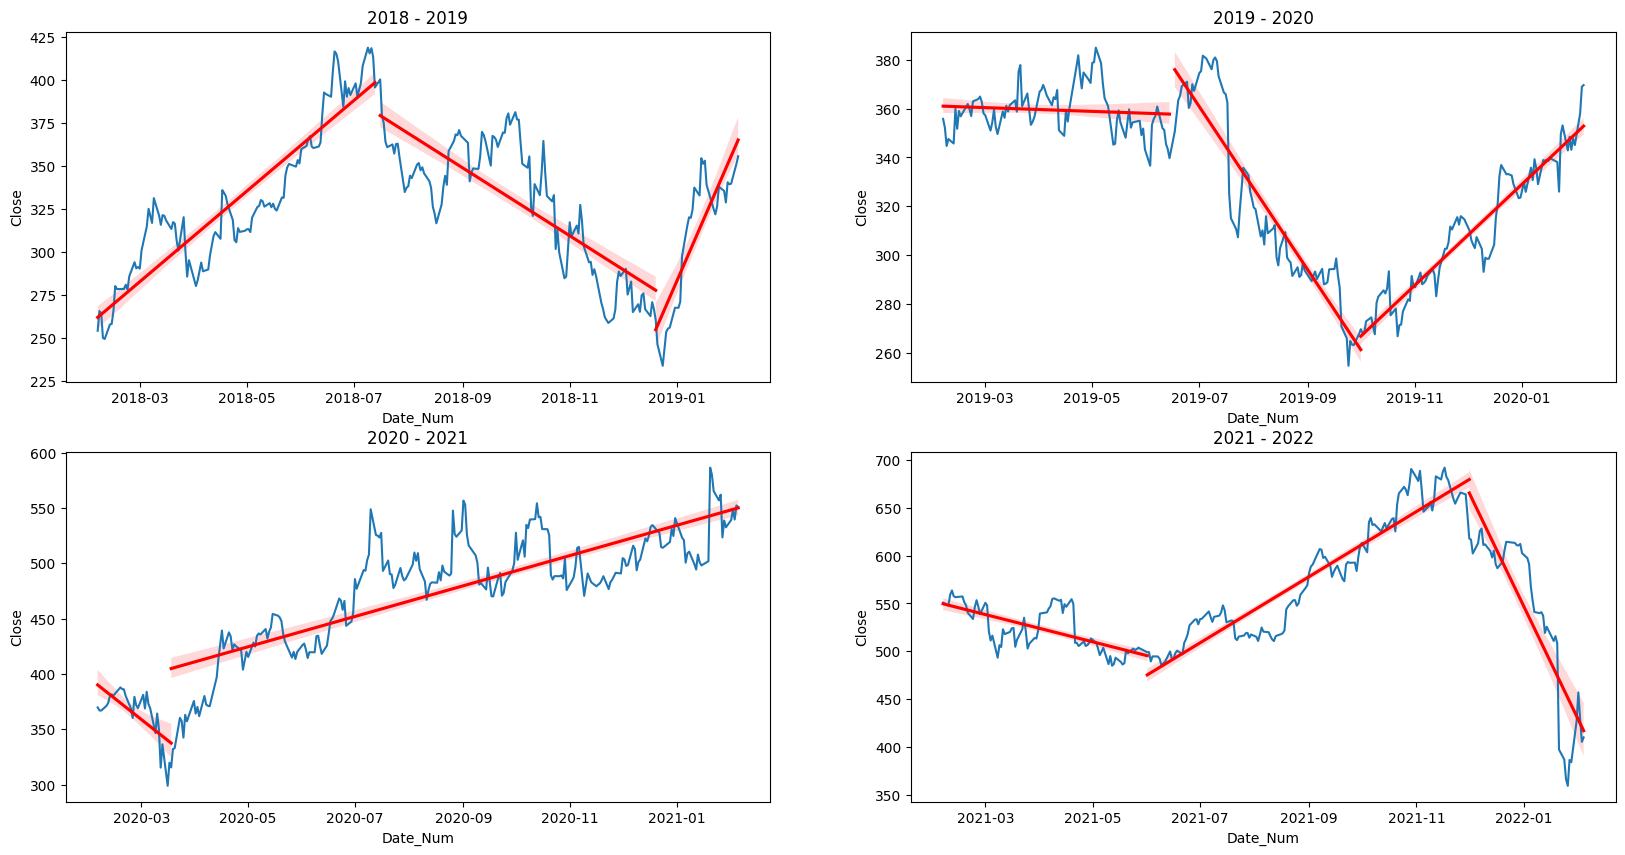

In [14]:
## Time series graph of each year interval
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

df["Date_Num"] = mdates.date2num(df.index)
# 2018 - 2019
ax[0, 0].plot(df.loc["2018-02-05" : "2019-02-05"].index, df.loc["2018-02-05" : "2019-02-05", "Close"])
sns.regplot(x = df.loc["2018-02-05" : "2018-07-15", "Date_Num"], y = df.loc["2018-02-05" : "2018-07-15", "Close"], ax = ax[0, 0], scatter = False, color = "r")
sns.regplot(x = df.loc["2018-07-15" : "2018-12-20", "Date_Num"], y = df.loc["2018-07-15" : "2018-12-20", "Close"], ax = ax[0, 0], scatter = False, color = "r")
sns.regplot(x = df.loc["2018-12-20" : "2019-02-05", "Date_Num"], y = df.loc["2018-12-20" : "2019-02-05", "Close"], ax = ax[0, 0], scatter = False, color = "r")
ax[0, 0].set_title("2018 - 2019")

# 2019 - 2020
ax[0, 1].plot(df.loc["2019-02-05" : "2020-02-05"].index, df.loc["2019-02-05" : "2020-02-05", "Close"])
sns.regplot(x = df.loc["2019-02-05" : "2019-06-15", "Date_Num"], y = df.loc["2019-02-05" : "2019-06-15", "Close"], ax = ax[0, 1], scatter = False, color = "r")
sns.regplot(x = df.loc["2019-06-15" : "2019-10-01", "Date_Num"], y = df.loc["2019-06-15" : "2019-10-01", "Close"], ax = ax[0, 1], scatter = False, color = "r")
sns.regplot(x = df.loc["2019-10-01" : "2020-02-05", "Date_Num"], y = df.loc["2019-10-01" : "2020-02-05", "Close"], ax = ax[0, 1], scatter = False, color = "r")
ax[0, 1].set_title("2019 - 2020")

# 2020 - 2021
ax[1, 0].plot(df.loc["2020-02-05" : "2021-02-05"].index, df.loc["2020-02-05" : "2021-02-05", "Close"])
sns.regplot(x = df.loc["2020-02-05" : "2020-03-18", "Date_Num"], y = df.loc["2020-02-05" : "2020-03-18", "Close"], ax = ax[1, 0], scatter = False, color= "r")
sns.regplot(x = df.loc["2020-03-18" : "2021-02-05", "Date_Num"], y = df.loc["2020-03-18" : "2021-02-05", "Close"], ax = ax[1, 0], scatter = False, color= "r")
ax[1, 0].set_title("2020 - 2021")

# 2021 - 2022
ax[1, 1].plot(df.loc["2021-02-05" : "2022-02-04"].index, df.loc["2021-02-05" : "2022-02-04", "Close"])
sns.regplot(x = df.loc["2021-02-05" : "2021-06-01", "Date_Num"], y = df.loc["2021-02-05" : "2021-06-01", "Close"], ax = ax[1, 1], scatter = False, color= "r")
sns.regplot(x = df.loc["2021-06-01" : "2021-12-01", "Date_Num"], y = df.loc["2021-06-01" : "2021-12-01", "Close"], ax = ax[1, 1], scatter = False, color= "r")
sns.regplot(x = df.loc["2021-12-01" : "2022-02-04", "Date_Num"], y = df.loc["2021-12-01" : "2022-02-04", "Close"], ax = ax[1, 1], scatter = False, color= "r")
ax[1, 1].set_title("2021 - 2022")

plt.show()

General pattern from periodicity of the graphs:
* 2018 - 2019 : Significant rise -> Drop around mid-2018 -> Recovery towards early 2019
* 2019 - 2020 : Stable period -> Decline around mid-late 2019 -> Recovery towards start of 2020
* 2020 - 2021 : Sharp Drop until Mid March 2020 -> Steady increase with fluctuations (General Upward Trend)
* 2021- 2022 : Stable (Slightly Decreasing) period -> Rise starting from mid 2021 and reaches peak at late 2021 -> Sharp Decline towards early 2022

Prediction:
* 2022 - Onwards : Could be predicted that it will have a significant recovery and rise again based on the trend as the stock trendline follows a "M" curved periodic trend of Up -> Down -> Stable / Up -> Down

## Modeling


### Train Data and Test Data
* Time Series:
    * Valid Data and Test Data needs to be more recent than Train Data as the model uses the data in the past to forecast

In [15]:
# Train Data : Test Data => 60 : 40
## Train Data 60% , 20% Validation Data , 20% Test Data
length_train = int(0.6 * len(df))   ## Train Data Size
length_val = int(0.2 * len(df))     ## Validation Data Size
length_test = int(0.2 * len(df))    ## Test Data Size

print(f"Size of each Data Sets: \nTrain: {length_train}\nValidation: {length_val}\nTest: {length_test}")

Size of each Data Sets: 
Train: 605
Validation: 201
Test: 201


### Data Scaling
* The units and number figures in the Volume column are way larger than other colums as there are numerously many trades for the stock => Need to apply scaling as a whole before training

In [16]:
scaler = MinMaxScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])

### Create Time Series Sequences

In [17]:
# Set Parameters
sequence_length = 3
batch_size = 32

# Prepare sequences and targets
x = df["Close"].values
y = df["Close"].values

# Create Datasets
train_dataset = timeseries_dataset_from_array(
    data = x[:length_train + sequence_length - 1],
    targets = y[sequence_length : length_train + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

validation_dataset = timeseries_dataset_from_array(
    data = x[length_train : length_train + length_val + sequence_length - 1],
    targets = y[length_train + sequence_length : length_train + length_val + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

test_dataset = timeseries_dataset_from_array(
    data = x[length_train + length_val : length_train + length_val + length_test + sequence_length - 1],
    targets = y[length_train + length_val + sequence_length : length_train + length_val + length_test + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

In [18]:
for samples, targets in train_dataset:
    print("Input shape:", samples.shape)
    print("Target shape:", targets.shape)
    break

Input shape: (32, 3)
Target shape: (32,)


### Create LSTM Layer model

In [19]:
# Generate Model

model = Sequential([
    LSTM(64, input_shape = (sequence_length, 1)),
    Dense(32, activation = "relu"),
    Dense(16, activation = "relu"),
    Dense(1, activation = "linear")
])

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = "mse",
    metrics = ["mse"]
)

history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = validation_dataset,
                    callbacks = [ModelCheckpoint("bese_dese_model.keras", save_best_only = True)])


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 -

### Evaluation

In [20]:
# Extract X_test and y_test from dataset
X_test = []
y_test = []

for samples, targets in test_dataset:
  X_test.append(samples.numpy())
  y_test.append(targets.numpy())

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

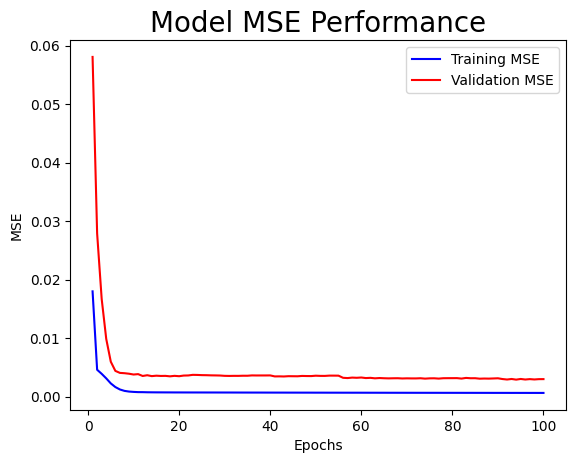

In [21]:
# Plot MAE and MSE
loss_mse = history.history["mse"]
val_mse = history.history["val_mse"]
epochs = np.arange(1, len(loss_mse) + 1)
plt.plot(epochs, loss_mse, color = "blue", label = "Training MSE")
plt.plot(epochs, val_mse, color = "red", label = "Validation MSE")
plt.title("Model MSE Performance", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [22]:
evaluation = model.evaluate(test_dataset)
print(f"MSE: {evaluation[0]}\nMAE: {evaluation[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mse: 0.0057 
MSE: 0.008483745157718658
MAE: 0.008483745157718658


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


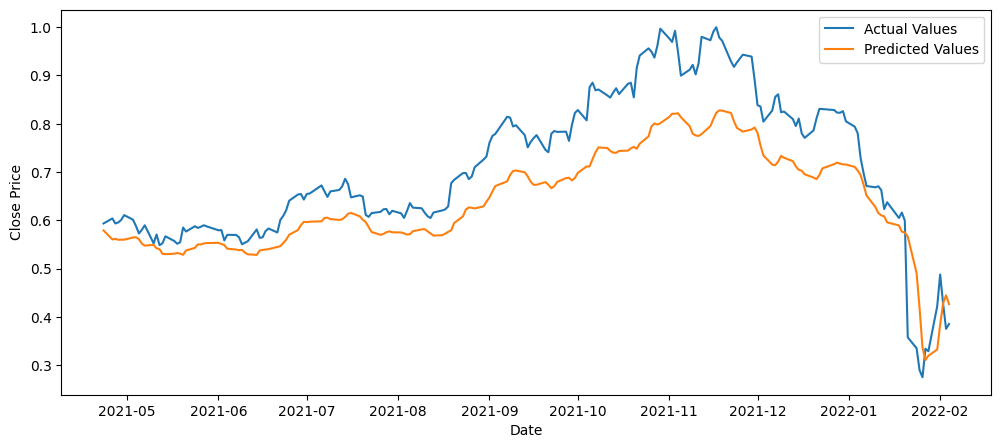

In [23]:
## Predictions
predict_test = model.predict(X_test)
test_dates = df.index[length_train + length_val + sequence_length:length_train + length_val + length_test + sequence_length]

# Plot predictions against actual values for Closed prices
plt.figure(figsize = (12, 5))
plt.plot(test_dates, y_test, label = "Actual Values")
plt.plot(test_dates, predict_test, label = "Predicted Values")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### Hyperparameter Tuning
* Attempt to increase performance of the model through tuning hyperparameters to optimized values through Keras Tuner

In [24]:
# Install Keras Tuner for hyperparameter tuning
!pip install -q -U keras-tuner

In [57]:
# Delete existing tuning directory for re-run
import os
import shutil
tuner_directory = "hptuner"
if os.path.exists(tuner_directory):
  shutil.rmtree(tuner_directory)

In [60]:
# Model Building
def model_builder(hp):
  model = Sequential()

  # Tune Drop Out Rate
  dropout_rate = hp.Float("dropout_rate", min_value = 0.1, max_value = 0.5, step = 0.1)
  # Tune Learning Rate
  hp_learning_rate = hp.Choice("learning_rate", values = [0.0005, 0.0001, 0.001, 0.01])

  # Add Input Layer
  model.add(LSTM(units = hp.Int("Input_LSTM_units", min_value = 64, max_value = 128, step = 32),
                 input_shape = (sequence_length, 1)))

  model.add(Dropout(dropout_rate))
  model.add(Dense(units = hp.Int(f"dense_units1", min_value = 16, max_value = 64, step = 16),
                      activation = "relu"))

  model.add(Dropout(dropout_rate))
  model.add(Dense(units = hp.Int(f"dense_units2", min_value = 36, max_value = 64, step = 16),
                      activation = "relu"))
  model.add(Dropout(dropout_rate))
  # Output Layer
  model.add(Dense(units = 1, activation = "linear"))

  # Compile
  optimizer = hp.Choice("optimizer", values = ["adam", "rmsprop"])
  if optimizer == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)

  elif optimizer == "rmsprop":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = hp_learning_rate)

  model.compile(
      optimizer = optimizer,
      loss = "mse",
      metrics = ["mse"]
  )

  return model

In [61]:
# Create Keras Hyperband for Tuning
objective = kt.Objective(
    name = "val_mse",
    direction = "min"
)

hptuner = kt.BayesianOptimization(
    model_builder,
    objective = objective,
    max_trials = 100,
    executions_per_trial = 2,
    directory = "hptuner",
    project_name = "stock_price_prediction"
)

callbacks = [EarlyStopping(monitor = "val_mse", patience = 3), ModelCheckpoint("best_model.keras", save_best_only = True)]

# Searching
hptuner.search(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Trial 100 Complete [00h 00m 46s]
val_mse: 0.0024541012826375663

Best val_mse So Far: 0.0011270264512859285
Total elapsed time: 01h 16m 17s


In [62]:
# Get best hyperparameters
best_hps = hptuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'dropout_rate': 0.30000000000000004,
 'learning_rate': 0.0005,
 'Input_LSTM_units': 128,
 'dense_units1': 48,
 'dense_units2': 52,
 'optimizer': 'rmsprop'}

In [63]:
# Train Optimized Model
opt_model = hptuner.hypermodel.build(best_hps)
opt_history = opt_model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = [EarlyStopping(monitor = "val_mse", patience = 3), ModelCheckpoint("best_model.keras", save_best_only = True)]
    )

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0565 - val_mse: 0.0565
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.004

### Evaluation

In [64]:
# Evaluate after tuning
best_evaluation = opt_model.evaluate(test_dataset)
print(f"MSE: {best_evaluation[0]}\nMAE: {best_evaluation[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mse: 0.0020
MSE: 0.002963610226288438
MAE: 0.002963610226288438


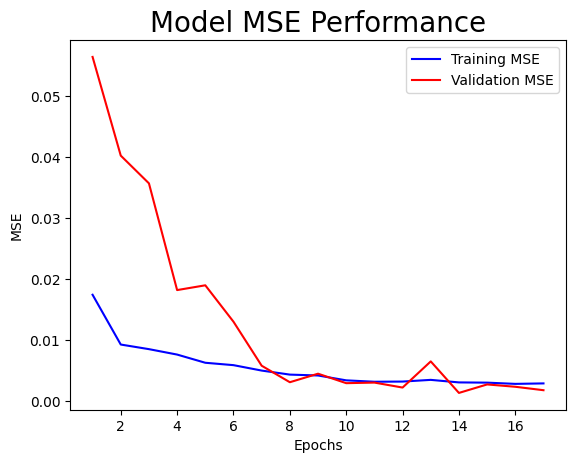

In [65]:
# Plot MAE and MSE
loss_mse = opt_history.history["mse"]
val_mse = opt_history.history["val_mse"]
epochs = np.arange(1, len(loss_mse) + 1)
plt.plot(epochs, loss_mse, color = "blue", label = "Training MSE")
plt.plot(epochs, val_mse, color = "red", label = "Validation MSE")
plt.title("Model MSE Performance", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


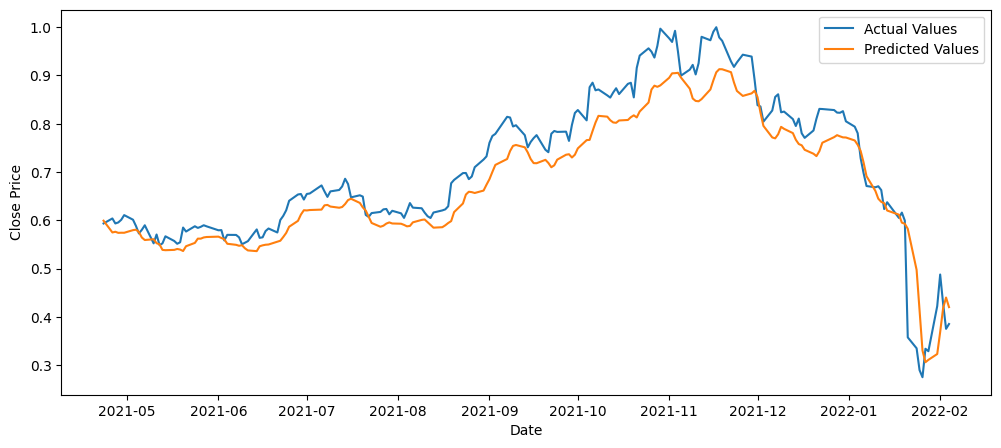

In [66]:
## Predictions
predict_test = opt_model.predict(X_test)
test_dates = df.index[length_train + length_val + sequence_length:length_train + length_val + length_test + sequence_length]

# Plot predictions against actual values for Closed prices
plt.figure(figsize = (12, 5))
plt.plot(test_dates, y_test, label = "Actual Values")
plt.plot(test_dates, predict_test, label = "Predicted Values")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()